In [1]:
import bayes3d as b
import trimesh
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
def open3d_mesh_to_trimesh(mesh):
    return trimesh.Trimesh(
        vertices=np.asarray(mesh.vertices),
        faces=np.asarray(mesh.triangles)
    )

In [2]:
from bayes3d.rendering.nvdiffrast_jax.jax_renderer import Renderer as JaxRenderer
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=200.0, fy=200.0,
    cx=100.0, cy=100.0,
    near=0.1, far=3.5
)
jax_renderer = JaxRenderer(intrinsics)

In [3]:
import os
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 10
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
m = b.utils.load_mesh(mesh_path)
mesh = b.utils.scale_mesh(m, 1.0/100.0)

In [39]:
def xfm_points(points, matrix):
    points = jnp.concatenate([points, jnp.ones((*points.shape[:-1],1))], axis=-1)
    return jnp.matmul(points, matrix.T)

projection_matrix = b.camera._open_gl_projection_matrix(
    intrinsics.height, intrinsics.width, 
    intrinsics.fx, intrinsics.fy, 
    intrinsics.cx, intrinsics.cy, 
    intrinsics.near, intrinsics.far
)
self = jax_renderer
gt_z = 2.0

pose = b.transform_from_pos(jnp.array([0.0, 0.0, gt_z]))
object_pose = pose
vertices = mesh.vertices
faces = mesh.faces
final_mtx_proj = projection_matrix @ object_pose
posw = jnp.concatenate([vertices, jnp.ones((*vertices.shape[:-1],1))], axis=-1)
pos_clip_ja = xfm_points(vertices, final_mtx_proj)


def render(object_pose):
    final_mtx_proj = projection_matrix @ object_pose
    posw = jnp.concatenate([vertices, jnp.ones((*vertices.shape[:-1],1))], axis=-1)
    pos_clip_ja = xfm_points(vertices, final_mtx_proj)
    (rast_out, rast_out_db), saved_tensors = jax_renderer._rasterize_fwd(pos_clip_ja[None,...], faces, jnp.array([intrinsics.height, intrinsics.width]))
    # return rast_out[...,3],rast_out[...,3], rast_out.sum(), rast_out
    gb_pos,_ = jax_renderer.interpolate(posw[None,...], rast_out, faces, rast_out_db, jnp.array([0,1,2,3]))
    mask = rast_out[..., -1] > 0
    shape_keep = gb_pos.shape
    gb_pos = gb_pos.reshape(shape_keep[0], -1, shape_keep[-1])
    gb_pos = gb_pos[..., :3]
    depth = xfm_points(gb_pos, pose)
    depth = depth.reshape(shape_keep)[..., 2] * -1
    return depth, mask, mask.sum(), rast_out
    
jax.clear_caches()
grad_func = jax.jit(render)
grad_func_no_jit = render

(1, 200, 200)
2916


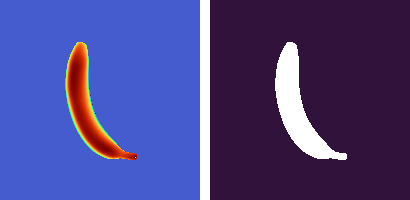

In [42]:
gt_z = 3.1
object_pose = b.transform_from_pos(jnp.array([0.0, 0.0, gt_z]))
gt_img,gt_mask,tmp,_ = render(object_pose)
print(gt_mask.shape)
print(tmp.sum())
b.hstack_images([b.get_depth_image(gt_img[0,...]), b.get_depth_image(gt_mask[0,...]*1.0)])

jitted
2916
non jitted
2916


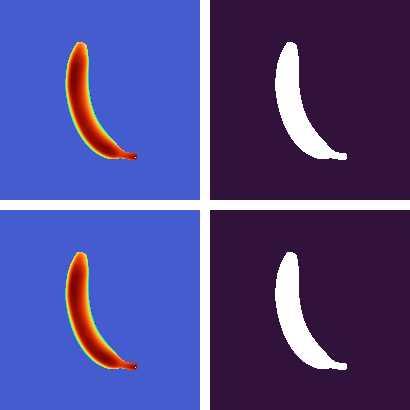

In [43]:
gt_z = 3.1
object_pose = b.transform_from_pos(jnp.array([0.0, 0.0, gt_z]))
print("jitted")
img, mask,tmp,_ = grad_func(object_pose)
print(tmp.sum())
print("non jitted")
img2, mask2,tmp,_ = grad_func_no_jit(object_pose)
print(tmp.sum())
b.vstack_images(
    [b.hstack_images([b.get_depth_image(img[0,...]), b.get_depth_image(mask[0,...]*1.0)]),
    b.hstack_images([b.get_depth_image(img2[0,...]), b.get_depth_image(mask2[0,...]*1.0)])]
)

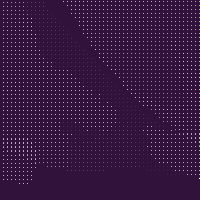

In [215]:
b.get_depth_image(img[0,...])

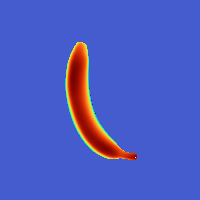

In [61]:
b.get_depth_image(img[0,...])

In [ ]:
# print(jnp.all(grad_func_no_jit(gt_z, gt_img) == grad_func(gt_z, gt_img)))
print("grad_func ", grad_func(gt_z, gt_img)[1][:10,:10])
print("grad_func_no_jit ", grad_func_no_jit(gt_z, gt_img)[1][:10,:10])
print("grad_func ", grad_func(gt_z, gt_img)[1][:10,:10])
img, mask = grad_func(gt_z, gt_img)

In [40]:
print(img[0,:10,:10])
print(gt_img[0,:10,:10])

[[-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]]
[[-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1]
 [-3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.1 -3.

In [ ]:
grad_func(gt_z, gt_img)

In [83]:
def loss(z, gt_img):
    pose = b.transform_from_pos(jnp.array([0.0, 0.0, z]))
    img,_ = render(mesh.vertices, mesh.faces, pose, intrinsics, None)
    return jnp.abs(gt_img - img).mean()
grad_func = jax.jit(jax.value_and_grad(loss, argnums=(0,)))
grad_func_no_jit = jax.value_and_grad(loss, argnums=(0,))
print("loss ", loss(gt_z, gt_img))
print("grad_func ", grad_func(gt_z, gt_img))
print("grad_func_no_jit ", grad_func_no_jit(gt_z, gt_img))

loss  0.0
New Plugin
New Plugin
New Plugin
New Plugin
grad_func  (Array(0.7484363, dtype=float32), (Array(0.03921415, dtype=float32, weak_type=True),))
grad_func_no_jit  (Array(0., dtype=float32), (Array(0.08212008, dtype=float32, weak_type=True),))


In [86]:
from tqdm import tqdm
z = 2.5
pbar = tqdm(range(100))
for _ in pbar:
    loss,grad =  grad_func_no_jit(z, gt_img)
    z = z - 0.1 * grad[0]
    pbar.set_description(f"{loss} z: {z}")

0.25600025057792664 z: 2.6366376876831055: 100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.01it/s]


0.4528703


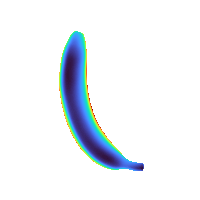

In [87]:
pose = b.transform_from_pos(jnp.array([0.0, 0.0, z]))
img = jax_renderer.render(mesh.vertices, mesh.faces, pose, intrinsics, None)
print(
    jnp.abs(gt_img - img).mean()
)
b.get_depth_image(img[0,...])


In [42]:
grad_func(z)

(Array(0.20323582, dtype=float32),
 (Array(-0.09783504, dtype=float32, weak_type=True),))

In [39]:
jnp.abs(gt_img - img).mean()

Array(0., dtype=float32)

In [37]:
grad_func(2.5)

(Array(0.20323582, dtype=float32),
 (Array(-0.09783504, dtype=float32, weak_type=True),))

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7040/static/


In [5]:
mesh = open3d_mesh_to_trimesh(o3d.geometry.TriangleMesh.create_sphere(resolution=2))
b.show_trimesh("tetra", mesh)
base_vertices = jnp.array(mesh.vertices)
base_faces = jnp.array(mesh.faces)

b.clear()
b.show_cloud("1",mesh.vertices)

data = jnp.load("gaussians_banana.npz")
print(data.files)
means  = data["mus"]
covs = data["choleskys"]
print(covs.shape)

['mus', 'covs', 'choleskys', 'mean_colors', 'nums']
(50, 3, 3)


In [7]:
def get_transformed_vertices(center, cov):
    return base_vertices @ (3.0 * cov.T) + center
all_vertices = jax.vmap(get_transformed_vertices, in_axes=(0,0))(means, covs)
print(all_vertices.shape)
all_faces = (jnp.arange(all_vertices.shape[0]) * base_vertices.shape[0])[:,None, None] + base_faces[None,...]
print(all_faces.shape)

# mesh = trimesh.Trimesh(vertices=base_vertices.reshape(-1,3), faces=base_faces.reshape(-1,3))
mesh = trimesh.Trimesh(vertices=all_vertices.reshape(-1,3), faces=all_faces.reshape(-1,3))

b.clear()
b.show_trimesh("1",mesh)

(50, 6, 3)
(50, 8, 3)


In [9]:
jax_renderer = JaxRenderer(intrinsics)

New Plugin


In [ ]:
b.setup_renderer(intrinsics)

In [ ]:
import os
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 10
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
m = b.utils.load_mesh(mesh_path)
m = b.utils.scale_mesh(m, 1.0/100.0)

In [ ]:
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/100.0)

In [ ]:
pose = b.transform_from_pos(jnp.array([0.0, 0.0, 0.5]))
img = b.RENDERER.render(pose[None,...], jnp.array([0]))
print(img[...,2])
b.get_depth_image(img[...,2])

In [28]:
jax_renderer = JaxRenderer(intrinsics)
def xfm_points(points, matrix):
    points = jnp.concatenate([points, jnp.ones((*points.shape[:-1],1))], axis=-1)
    return jnp.matmul(points, matrix.T)

def render(vertices, faces, object_pose, projection_matrix):
    final_mtx_proj = projection_matrix @ pose
    posw = jnp.concatenate([vertices, jnp.ones((*vertices.shape[:-1],1))], axis=-1)
    pos_clip_ja = xfm_points(vertices, final_mtx_proj)

    rast_out, rast_out_db = jax_renderer.rasterize(pos_clip_ja[None,...], faces, jnp.array([intrinsics.height, intrinsics.width]))
    gb_pos,_ = jax_renderer.interpolate(posw[None,...], rast_out, faces, rast_out_db, jnp.array([0,1,2,3]))
    mask = rast_out[..., -1] > 0
    shape_keep = gb_pos.shape
    gb_pos = gb_pos.reshape(shape_keep[0], -1, shape_keep[-1])
    gb_pos = gb_pos[..., :3]
    depth = xfm_points(gb_pos, pose)
    depth = depth.reshape(shape_keep)[..., 2] * -1
    return -depth * mask + intrinsics.far * (1.0 - mask)
    # rast_out, _ = jax_renderer.rasterize(new_cloud[None,...], jnp.array(b.RENDERER.meshes[0].faces), jnp.array([intrinsics.height, intrinsics.width]))


New Plugin


In [10]:
proj = b.camera._open_gl_projection_matrix(
    intrinsics.height, intrinsics.width, 
    intrinsics.fx, intrinsics.fy, 
    intrinsics.cx, intrinsics.cy, 
    intrinsics.near, intrinsics.far
)
%%time
img = render(b.RENDERER.meshes[0].vertices, b.RENDERER.meshes[0].faces, pose, proj)
b.get_depth_image(img[0,...])

NameError: name 'intrinsics' is not defined

In [36]:
%%time
img = render(b.RENDERER.meshes[0].vertices, b.RENDERER.meshes[0].faces, pose, proj)

CPU times: user 43.8 ms, sys: 4.85 ms, total: 48.6 ms
Wall time: 41 ms


In [262]:
cloud =b.apply_transform_jit(b.RENDERER.meshes[0].vertices, pose)
b.show_cloud("1",cloud)
cloudw = b.add_homogenous_ones(cloud)
print(cloudw)

[[-0.47551    -0.60295     0.55166     1.        ]
 [-0.49817002 -0.05815     0.41496     1.        ]
 [-0.3009     -0.85954005  0.37413     1.        ]
 ...
 [ 0.09810001  0.80452     0.61273     1.        ]
 [ 0.07996     0.84863     0.59165     1.        ]
 [ 0.10651     0.83125     0.60057     1.        ]]


In [263]:
proj = b.camera.getProjectionMatrix(intrinsics)
proj = b.camera._open_gl_projection_matrix(
    intrinsics.height, intrinsics.width, 
    intrinsics.fx, intrinsics.fy, 
    intrinsics.cx, intrinsics.cy, 
    intrinsics.near, intrinsics.far
)
new_cloud = cloudw @ proj.T
print(new_cloud.shape)
print(new_cloud)
b.show_cloud("2",new_cloud[:,:3] / new_cloud[:,3][...,None],color=b.RED)

(10710, 4)
[[-0.9482617  -1.2031417   0.297355    0.55166   ]
 [-0.99426526 -0.1142252   0.17204665  0.41496   ]
 [-0.5999294  -1.7172095   0.13461916  0.37413   ]
 ...
 [ 0.19926366  1.6121037   0.35333586  0.61273   ]
 [ 0.16287825  1.7002183   0.3340125   0.59165   ]
 [ 0.21602285  1.6655029   0.3421892   0.60057   ]]


In [264]:
jax_renderer = JaxRenderer(intrinsics)

New Plugin


In [267]:
rast_out[0,...,-1]

Array([[2040., 2040., 2040., ...,    0.,    0.,    0.],
       [2045., 2045., 2045., ...,    0.,    0.,    0.],
       [2045., 2045., 2045., ...,    0.,    0.,    0.],
       ...,
       [5749., 5287., 5287., ...,    0.,    0.,    0.],
       [5749., 5287., 5287., ...,    0.,    0.,    0.],
       [5287., 5287., 5287., ...,    0.,    0.,    0.]], dtype=float32)

49054730.0
[    0.  2040.  2045.  2048.  2050.  2055.  2062.  2072.  2079.  2085.
  2090.  2093.  2095.  2101.  2110.  2115.  2130.  2132.  2136.  2140.
  2143.  2149.  2155.  2159.  2166.  2168.  2185.  2191.  2194.  2205.
  2207.  2218.  2227.  2238.  2245.  2247.  2341.  2343.  2346.  2353.
  2357.  2367.  2432.  2439.  2442.  2446.  2455.  2459.  2469.  2476.
  2477.  2479.  2488.  2499.  2511.  2522.  2525.  2528.  2530.  2542.
  2547.  2556.  2562.  2566.  2567.  2569.  2582.  2583.  2595.  2622.
  2639.  2646.  2651.  2652.  2659.  2663.  2668.  2674.  2681.  2687.
  2715.  2717.  2721.  2722.  2731.  2733.  2748.  2751.  2758.  2759.
  2760.  2771.  2779.  2782.  2783.  2787.  2790.  2797.  2806.  2811.
  2820.  2827.  2830.  2834.  2842.  2843.  2848.  2853.  2855.  2859.
  2864.  2867.  2869.  2871.  2874.  2875.  2887.  2888.  2889.  2891.
  2893.  2901.  2902.  2903.  2909.  2910.  2912.  2913.  2916.  2919.
  2920.  2923.  2924.  2926.  2927.  2929.  2932.  2933.  2936.  2

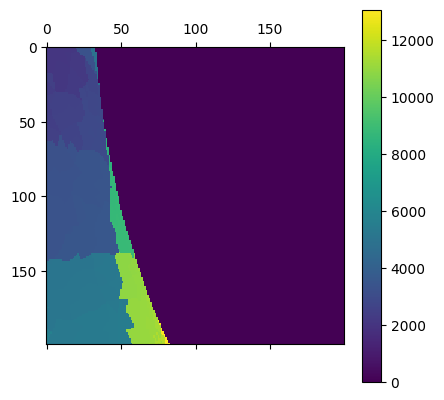

In [269]:
rast_out, _ = jax_renderer.rasterize(new_cloud[None,...], jnp.array(b.RENDERER.meshes[0].faces), jnp.array([intrinsics.height, intrinsics.width]))
print(rast_out.sum())
plt.matshow(rast_out[0,...,-1])
print(jnp.unique(rast_out[0,...,-1]))
plt.colorbar()

In [244]:
jnp.array(b.RENDERER.meshes[0].faces)

Array([[4039,    1, 1769],
       [1767,    1, 4039],
       [  35, 1427, 1424],
       ...,
       [6504, 7864, 7863],
       [6470, 7865, 7842],
       [6470, 6483, 7865]], dtype=int32)

In [188]:
x=1.0
n=0.01
f=5.0
proj = np.array([[n/x,    0,            0,              0],
                 [  0,  n/x,            0,              0],
                 [  0,    0, -(f+n)/(f-n), -(2*f*n)/(f-n)],
                 [  0,    0,           -1,              0]])
new_cloud = b.apply_transform_jit(-cloud, proj.T)
b.show_cloud("2",new_cloud,color=b.RED)

In [176]:
new_cloud

Array([[-0.95102   , -1.2059    ,  2.0390978 ],
       [-0.99634004, -0.1163    ,  1.9018998 ],
       [-0.6018    , -1.7190801 ,  1.860921  ],
       ...,
       [ 0.19620001,  1.60904   ,  2.1003904 ],
       [ 0.15991999,  1.69726   ,  2.0792334 ],
       [ 0.21302   ,  1.6625    ,  2.088186  ]], dtype=float32)